In [116]:
pip install tensorflow --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 999.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 45.1 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [1]:
# Cell 1 - Import Libraries
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import pandas as pd
import numpy as np

In [10]:
# Tentukan path file yang ingin digabungkan
file_path_1 = "/content/PASA_Weak.csv"
file_path_2 = "/content/PASA_Medium.csv"
file_path_3 = "/content/PASA_Strong.csv"

# Tentukan path file output gabungan
output_file_path = "/content/FullData_processed.csv"

# Membaca ketiga file dan menyatukannya
with open(output_file_path, 'w') as output_file:
    # Menulis isi file pertama
    with open(file_path_1, 'r') as file1:
        output_file.write(file1.read())

    # Menambahkan isi file kedua
    with open(file_path_2, 'r') as file2:
        output_file.write(file2.read())

    # Menambahkan isi file ketiga
    with open(file_path_3, 'r') as file3:
        output_file.write(file3.read())

# Menampilkan pesan sukses
print(f"File gabungan berhasil disimpan di {output_file_path}")


File gabungan berhasil disimpan di /content/FullData_processed.csv


In [11]:
import re
import pandas as pd

# Ganti dengan path file yang sesuai
file_path = "/content/FullData_processed.csv"

# List untuk menyimpan data setelah pemisahan
split_data = []

with open(file_path, 'r') as file:
    for line in file:
        # Menghapus karakter newline
        line = line.strip()

        # Menggunakan regex untuk memisahkan pada koma yang berada sebelum angka (3, 2, atau 1)
        # Format regex untuk memilih koma hanya sebelum angka di akhir teks
        match = re.split(r',(?!.*,) *(?=\d+$)', line)  # (?=...$) memastikan angka di akhir
        split_data.append(match)

# Membuat DataFrame dari split_data
df = pd.DataFrame(split_data)

# Menampilkan DataFrame sebagai tabel
print(df)

# Jika ingin menyimpan hasilnya dalam bentuk CSV
output_path = "FullData_processed.csv"
df.to_csv(output_path, index=False)


                             0     1
0      Password,Strength_Level  None
1                 Activate9999     1
2                 bbbbadjurer4     1
3                 asdfadinole5     1
4                  acetoinAsdf     1
...                        ...   ...
29997              Lv-e3U<{!AU     3
29998               aborad6E?X     3
29999             Aaro:/mnitic     3
30000            U+,R/Il!HDe<E     3
30001               achtel2IUn     3

[30002 rows x 2 columns]


In [13]:
# Baca file CSV, melewati baris pertama
df = pd.read_csv("/content/FullData_processed.csv", skiprows=1, names=["Password", "Strength_Level"])

df = df.iloc[1:].reset_index(drop=True)

# Periksa hasil
print(df.head())


       Password  Strength_Level
0  Activate9999             1.0
1  bbbbadjurer4             1.0
2  asdfadinole5             1.0
3   acetoinAsdf             1.0
4  qweabsurdly3             1.0


In [14]:
df.head()

,Password,Strength_Level
0,Activate9999,1.0
1,bbbbadjurer4,1.0
2,asdfadinole5,1.0
3,acetoinAsdf,1.0
4,qweabsurdly3,1.0


In [17]:
df_copy = df.copy()

In [18]:
# Cell 3 - Preprocess Data
label_encoder = LabelEncoder()

def preprocess_data(df):
    """Clean and prepare data"""
    df['Password'] = df['Password'].astype(str)
    df = df.dropna()

    # Encode labels
    df['Strength_Level'] = label_encoder.fit_transform(df['Strength_Level'])

    # Extract features
    print("Extracting features from password...")
    df['length'] = df['Password'].apply(len)
    df['uppercase'] = df['Password'].apply(lambda x: sum(c.isupper() for c in x))
    df['lowercase'] = df['Password'].apply(lambda x: sum(c.islower() for c in x))
    df['digits'] = df['Password'].apply(lambda x: sum(c.isdigit() for c in x))
    df['special'] = df['Password'].apply(lambda x: sum(not c.isalnum() for c in x))

    features = df[['length', 'uppercase', 'lowercase', 'digits', 'special']].values

    return df, features

df, features = preprocess_data(df)


Extracting features from password...


In [19]:
# Cell 4 - Tokenize Data
tokenizer = Tokenizer(char_level=True)

def tokenize_data(passwords, max_length=20):
    """Convert passwords to sequences"""
    tokenizer.fit_on_texts(passwords)

    sequences = tokenizer.texts_to_sequences(passwords)

    max_length = min(max_length, max(len(seq) for seq in sequences))
    padded_sequences = pad_sequences(sequences, maxlen=max_length)

    print(f"Vocabulary size: {len(tokenizer.word_index)}")
    print(f"Max sequence length: {max_length}")

    return padded_sequences, max_length

sequences, max_length = tokenize_data(df['Password'])


Vocabulary size: 62
Max sequence length: 20


In [20]:
# Cell 5 - Split Data
# Split data into train and test sets (80% train, 20% test)
X_seq_train, X_seq_test, X_feat_train, X_feat_test, y_train, y_test = train_test_split(
    sequences, features, df['Strength_Level'],
    test_size=0.2,
    random_state=42
)

# Further split the training set into training and validation sets (80% train, 20% validation)
X_seq_train, X_seq_val, X_feat_train, X_feat_val, y_train, y_val = train_test_split(
    X_seq_train, X_feat_train, y_train,
    test_size=0.2,
    random_state=42
)

In [21]:
# Cell 6 - Create Model
def create_model(vocab_size, max_length):
    """Create model architecture"""
    # Sequence input
    sequence_input = tf.keras.Input(shape=(max_length,))
    feature_input = tf.keras.Input(shape=(5,))

    # Embedding and Convolutional layers
    x1 = tf.keras.layers.Embedding(vocab_size + 1, 32)(sequence_input)
    x1 = tf.keras.layers.Conv1D(64, 3, activation='relu')(x1)
    x1 = tf.keras.layers.LSTM(32, return_sequences=True)(x1)
    x1 = tf.keras.layers.GlobalMaxPooling1D()(x1)

    # Concatenate sequence and feature inputs
    concatenated = tf.keras.layers.Concatenate()([x1, feature_input])

    # Fully connected layers
    x = tf.keras.layers.Dense(128, activation='relu')(concatenated)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)

    # Output layer
    output = tf.keras.layers.Dense(len(set(df['Strength_Level'])), activation='softmax')(x)

    model = tf.keras.Model(inputs=[sequence_input, feature_input], outputs=output)

    return model

model = create_model(len(tokenizer.word_index), max_length)


In [22]:
# Cell 7 - Compile Model
def compile_model(model):
    """Compile the model"""
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    print(model.summary())

compile_model(model)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 20)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 20, 32)         │          2,016 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 18, 64)         │          6,208 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 18, 32)         │         12,416 │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 32)             │              0 │ lstm[0][0]             │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 5)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 37)             │              0 │ global_max_pooling1d[… │
│                           │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │          4,864 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          8,256 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 32)             │          2,080 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 4)              │            132 │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 35,972 (140.52 KB)

 Trainable params: 35,972 (140.52 KB)

 Non-trainable params: 0 (0.00 B)

None


In [23]:
# Cell 8 - Train Model
def train_model(model, X_seq_train, X_feat_train, y_train, X_seq_val, X_feat_val, y_val, epochs=10, batch_size=32):
    """Train the model"""
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    history = model.fit(
        [X_seq_train, X_feat_train],
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=([X_seq_val, X_feat_val], y_val),
        callbacks=[early_stopping]
    )

    return history

history = train_model(model, X_seq_train, X_feat_train, y_train, X_seq_val, X_feat_val, y_val)


Epoch 1/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.6476 - loss: 0.7614 - val_accuracy: 0.8839 - val_loss: 0.2627
Epoch 2/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8885 - loss: 0.2629 - val_accuracy: 0.9305 - val_loss: 0.1621
Epoch 3/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9402 - loss: 0.1546 - val_accuracy: 0.9484 - val_loss: 0.1319
Epoch 4/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.9500 - loss: 0.1219 - val_accuracy: 0.9597 - val_loss: 0.0929
Epoch 5/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.9579 - loss: 0.0987 - val_accuracy: 0.9624 - val_loss: 0.0894
Epoch 6/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9640 - loss: 0.0849 - val_accuracy: 0.9470 - val_loss: 0.1204
Epoch 7/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.9637 - loss: 0.0864 - val_accuracy: 0.9630 - val_loss: 0.0826
Epoch 8/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9682 - loss: 0.0746 - val

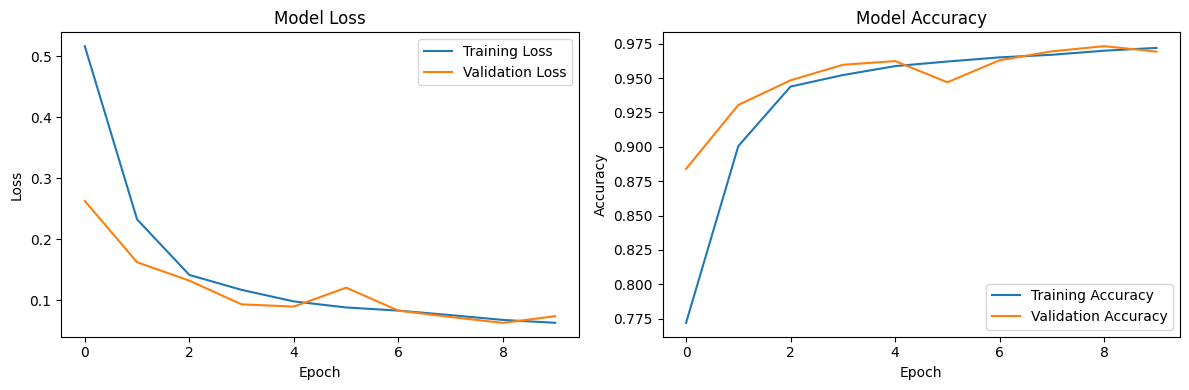

In [24]:
# Cell 9 - Plot Training History
def plot_training_history(history):
    """Plot training history"""
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


In [25]:
# Evaluate Model
def evaluate_model(model, X_seq_test, X_feat_test, y_test):
    """Evaluate model performance"""
    test_loss, test_accuracy = model.evaluate([X_seq_test, X_feat_test], y_test)
    print(f"\nTest accuracy: {test_accuracy:.4f}")
    return test_loss, test_accuracy

test_loss, test_accuracy = evaluate_model(model, X_seq_test, X_feat_test, y_test)


188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9703 - loss: 0.0676

Test accuracy: 0.9686


In [48]:
# Predict Password Strength
def predict_password(model, password, tokenizer, max_length):
    """Predict the strength of a single password"""
    # Preprocess the password
    sequence = tokenizer.texts_to_sequences([password])
    padded_sequence = pad_sequences(sequence, maxlen=max_length)

    # Extract features for the password
    features = np.array([[len(password),
        sum(c.isupper() for c in password),
        sum(c.islower() for c in password),
        sum(c.isdigit() for c in password),
        sum(not c.isalnum() for c in password)
    ]])

    # Predict password strength
    prediction = model.predict([padded_sequence, features])
    strength_idx = np.argmax(prediction[0])
    confidence = float(np.max(prediction[0]))

    # Convert numerical strength index to descriptive label
    strength_labels = {0: "lemah", 1: "sedang", 2: "kuat"}
    strength = strength_labels.get(strength_idx, "Tidak diketahui")

    return strength, confidence

# Test with new passwords
test_passwords = ["thanos>?", "P@ssw0r#$%&*)$", "Str0ng!P@ssw0r#$%&*)$$%d123"]
for password in test_passwords:
    strength, confidence = predict_password(model, password, tokenizer, max_length)
    print(f"\nPassword: {password}")
    print(f"Strength: {strength}")
    print(f"Confidence: {confidence:.2%}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Password: thanos>?
Strength: kuat
Confidence: 99.47%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Password: P@ssw0r#$%&*)$
Strength: kuat
Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Password: Str0ng!P@ssw0r#$%&*)$$%d123
Strength: kuat
Confidence: 100.00%


In [46]:
# Cell 11 - Predict Password Strength
def predict_password(model, password, tokenizer, max_length):
    """Predict the strength of a single password"""
    # Preprocess the password
    sequence = tokenizer.texts_to_sequences([password])
    padded_sequence = pad_sequences(sequence, maxlen=max_length)

    # Extract features for the password
    features = np.array([[len(password),
        sum(c.isupper() for c in password),
        sum(c.islower() for c in password),
        sum(c.isdigit() for c in password),
        sum(not c.isalnum() for c in password)
    ]])

    # Predict password strength
    prediction = model.predict([padded_sequence, features])
    strength_idx = np.argmax(prediction[0])
    confidence = float(np.max(prediction[0]))

    # Convert numerical strength index to descriptive label
    strength_labels = {0: "lemah", 1: "sedang", 2: "kuat"}
    strength = strength_labels.get(strength_idx, "Tidak diketahui")

    return strength, confidence

# Loop to continuously test passwords
while True:
    password = input("Masukkan kata sandi (atau ketik 'exit' untuk keluar): ")
    if password.lower() == 'exit':
        print("Program selesai.")
        break

    strength, confidence = predict_password(model, password, tokenizer, max_length)
    print(f"\nPassword: {password}")
    print(f"Strength: {strength}")
    print(f"Confidence: {confidence:.2%}")


Masukkan kata sandi (atau ketik 'exit' untuk keluar): tes123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Password: tes123
Strength: lemah
Confidence: 100.00%
Masukkan kata sandi (atau ketik 'exit' untuk keluar): tesCuyy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Password: tesCuyy
Strength: lemah
Confidence: 95.66%
Masukkan kata sandi (atau ketik 'exit' untuk keluar): tesCuyy123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Password: tesCuyy123
Strength: lemah
Confidence: 100.00%
Masukkan kata sandi (atau ketik 'exit' untuk keluar): tesCuyy@@#12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Password: tesCuyy@@#12
Strength: kuat
Confidence: 100.00%
Masukkan kata sandi (atau ketik 'exit' untuk keluar): exit
Program selesai.


In [36]:
# Konversi ke TensorFlow Lite dengan menonaktifkan experimental_lower_tensor_list_ops
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/my_model')
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Operasi bawaan TFLite
    tf.lite.OpsSet.SELECT_TF_OPS     # Operasi tambahan dari TensorFlow
]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

# Simpan model .tflite
with open('my_model.tflite', 'wb') as f:
    f.write(tflite_model)


In [37]:
import pickle

# Simpan model ke file Pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model berhasil disimpan dalam format Pickle.")


Model berhasil disimpan dalam format Pickle.


In [49]:
tf.keras.models.save_model(model, 'my_model.keras')

In [44]:
tf.keras.models.save_model(model, 'model.h5')

In [45]:
import pickle

# Simpan tokenizer ke file
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)
